In [32]:

import pandas as pd 
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


[nltk_data] Downloading package punkt to /Users/Cyrille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Cyrille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Cyrille/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
PATH_TO_EMOTIONS = "../data/emotions.csv"

In [34]:
emotions_data = pd.read_csv(PATH_TO_EMOTIONS)
emotions_data.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [35]:
emotions_data["label"].unique()

array(['anger', 'sadness', 'joy', 'love', 'fear', 'surprise'],
      dtype=object)

In [36]:
emotions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [37]:
# count total for each unique label
emotions_data["label"].value_counts()   

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

In [38]:
emotions_data.shape

(20000, 2)

In [39]:
stopwords = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text) 
    text = re.sub('\n', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    
    # remove any http words and href
    text = re.sub(r'http', '', text)
    text = re.sub(r'href', '', text)

    # tokenize text
    tokens = nltk.tokenize.word_tokenize(text)

    # remove stopwords
    tokens = [word for word in tokens if word not in stopwords]

    # lemmatize words 
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(word) for word in tokens]
    
    return " ".join(tokens)

In [40]:
emotions_data["text"] = emotions_data["text"].apply(clean_text)

In [41]:
emotions_data.head()

,text,label
0,feel pissed old friend friend,anger
1,ive found made huge difference especially fing...,anger
2,also feel unfortunate nearly reader going meet...,sadness
3,feel petty clairee,anger
4,used believe feeling like fear ignored suppres...,sadness


In [42]:
surprise = emotions_data[emotions_data["label"] == "surprise"]

In [43]:
surprise

,text,label
30,began feel curious tried percieve beneath pride,surprise
44,feel weird completely nothing,surprise
84,care care people disability targeted sensation...,surprise
141,hope keep handing book mormon feel impressed give,surprise
213,ive reading feeling pleasantly surprised find ...,surprise
...,...,...
19890,go around people act normal feel strange,surprise
19901,feel herpes coming would surprised point make ...,surprise
19915,like thing leave others feeling surprised deli...,surprise
19944,feel like monster make way rubble stunned body...,surprise


In [44]:
count_vectorizer = CountVectorizer()
a = count_vectorizer.fit_transform(emotions_data["text"])
a.shape

(20000, 15079)

In [45]:
texts = emotions_data["text"].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15100 unique tokens.


In [46]:
emotions_data["text"] = emotions_data["text"].apply(lambda x: tokenizer.texts_to_sequences([x])[0])

In [47]:
emotions_data.head()

,text,label
0,"[1, 401, 167, 43, 43]",anger
1,"[20, 220, 46, 902, 979, 172, 853, 1875, 579, 1...",anger
2,"[40, 1, 653, 1113, 625, 27, 676, 263, 2428, 12...",sadness
3,"[1, 551, 7534]",anger
4,"[222, 194, 2, 3, 479, 502, 3210, 37, 71, 95]",sadness


In [48]:
X, y = emotions_data["text"], emotions_data["label"]

In [49]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [50]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state = 42)

In [51]:
x_train = pad_sequences(x_train, maxlen=100)
x_test = pad_sequences(x_test, maxlen=100)
x_val = pad_sequences(x_val, maxlen=100)


In [52]:
y_train[:2], y_test[:2], y_val[:2]

(252      joy
 18632    joy
 Name: label, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object,
 17353    sadness
 16081      anger
 Name: label, dtype: object)

In [53]:
label_encoder = LabelEncoder()

# transform the labels to integers and then to one-hot encoded

y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)
y_val = to_categorical(y_val_encoded)


In [54]:
y_train_encoded[:10], y_test_encoded[:10], y_val_encoded[:10]

(array([2, 2, 1, 0, 3, 0, 0, 4, 2, 0]),
 array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1]),
 array([4, 0, 4, 4, 5, 1, 2, 1, 2, 4]))

In [55]:
def build_model(word_index):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
model = build_model(word_index=word_index)

In [57]:
history = model.fit(x_train, y_train, epochs=10, batch_size=128,validation_data=(x_val, y_val),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10


100/100 [==============================] - 36s 334ms/step - loss: 1.4700 - accuracy: 0.4357 - val_loss: 1.0745 - val_accuracy: 0.5981
Epoch 2/10
100/100 [==============================] - 33s 328ms/step - loss: 0.6133 - accuracy: 0.8009 - val_loss: 0.4674 - val_accuracy: 0.8409
Epoch 3/10
100/100 [==============================] - 34s 338ms/step - loss: 0.1914 - accuracy: 0.9398 - val_loss: 0.3038 - val_accuracy: 0.8959
Epoch 4/10
100/100 [==============================] - 34s 336ms/step - loss: 0.0879 - accuracy: 0.9720 - val_loss: 0.3036 - val_accuracy: 0.9044
Epoch 5/10
100/100 [==============================] - 34s 338ms/step - loss: 0.0539 - accuracy: 0.9827 - val_loss: 0.3253 - val_accuracy: 0.9006
Epoch 6/10
100/100 [==============================] - 46s 460ms/step - loss: 0.0421 - accuracy: 0.9871 - val_loss: 0.3306 - val_accuracy: 0.9019
Epoch 7/10
100/100 [==============================] - 49s 487ms/step - loss: 0.0312 - accuracy: 0.9902 - val_loss: 0.3796 - val_accuracy: 0.8

In [58]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss=history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'g', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.plot(epochs, loss, 'g', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

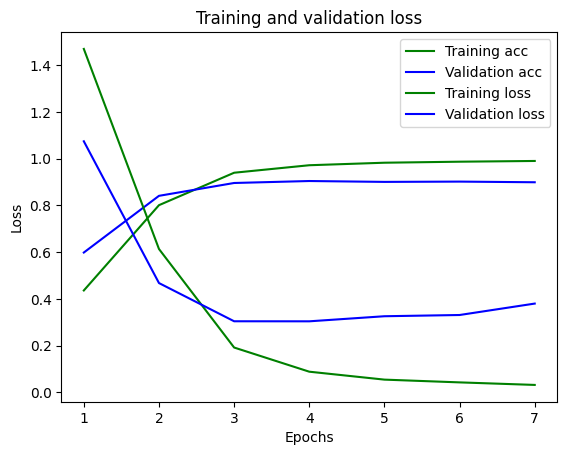

In [59]:
plot_history(history)

### Evaluate model with score on test data

In [60]:
model.evaluate(x_test, y_test)

125/125 [==============================] - 5s 34ms/step - loss: 0.3520 - accuracy: 0.8970


[0.3519844114780426, 0.8970000147819519]

In [61]:
preds = model.predict(x_test)

125/125 [==============================] - 5s 33ms/step


In [62]:
preds = preds.argmax(axis=1)

In [63]:
preds[:10]

array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1])

In [64]:
y_test = y_test.argmax(axis=1)

In [65]:
y_test[:10]

array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1])

### Confusion matrix for predicted vs actual data

In [66]:
def plot_confusion_matrix(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()  

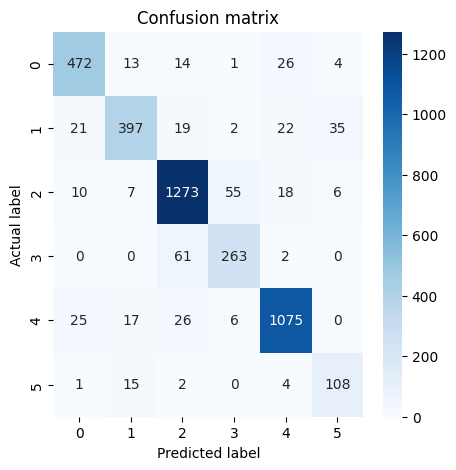

In [67]:
plot_confusion_matrix(y_test, preds)

In [68]:
def predict_emotion(text, model):
    text = clean_text(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=100)
    pred = model.predict(text)
    pred = pred.argmax(axis=1)
    return label_encoder.inverse_transform(pred)[0]

In [69]:
predict_emotion("I am so happy today!", model)

1/1 [==============================] - 1s 504ms/step


'joy'

In [70]:
predict_emotion("I am so sad today!", model)

1/1 [==============================] - 0s 55ms/step


'fear'

In [71]:
# surprise
predict_emotion("Wow i was so unaware of the news!", model)

1/1 [==============================] - 0s 53ms/step


'anger'

In [72]:
predict_emotion("I am so furious today!", model)

1/1 [==============================] - 0s 53ms/step


'anger'

In [73]:
predict_emotion("It was so unfortunate that I lost my job today!", model)

1/1 [==============================] - 0s 53ms/step


'sadness'

In [74]:
emotions_data_2 = pd.read_csv("../data/emotions.csv")

In [75]:
# love data 
love_data = emotions_data_2[emotions_data_2["label"] == "love"]

In [76]:
a = love_data["text"].iloc[100]
b = love_data["label"].iloc[100]
a,b 

('i had to have a blood test yesterday so perhaps im feeling particularly fond of it right now because of the doctors needle that was inside of me and the time spent with the dizzy head of a non meat eating nineteen year old female',
 'love')

In [77]:
predict_emotion(a, model), b

1/1 [==============================] - 0s 54ms/step


('love', 'love')

## Data augmentation


https://www.analyticsvidhya.com/blog/2022/02/text-data-augmentation-in-natural-language-processing-with-texattack/


https://towardsdatascience.com/data-augmentation-in-nlp-2801a34dfc28

In [78]:
from textattack.augmentation import WordNetAugmenter

/Users/Cyrille/Documents/aiml22/Deep learning/deep_learning_venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
word_aug = WordNetAugmenter()

[nltk_data] Downloading package omw-1.4 to /Users/Cyrille/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [80]:
word_aug.augment(a)

['i had to have a blood try yesterday so perhaps im tone particularly fond of it right now because of the doctors needle that was inside of me and the time spent with the dizzy headway of a non meat eating XIX year old female']

https://textattack.readthedocs.io/en/latest/2notebook/3_Augmentations.html

In [81]:
import pandas as pd

def augment_data(label, input_data):
    # Filter the DataFrame for the specified label
    data = input_data[input_data["label"] == label]

    # Create a list to store augmented rows
    augmented_rows = []

    # Loop through each text in the data
    for _, row in data.iterrows():
        
        # Generate augmented texts and add them as new rows
        for aug_text in word_aug.augment(row['text']):
            new_row = row.copy()
            new_row['text'] = aug_text
            augmented_rows.append(new_row)

    # Convert the list of rows into a DataFrame
    augmented_data = pd.DataFrame(augmented_rows, columns=data.columns)
    
    updated_emotions_data = pd.concat([input_data, augmented_data], ignore_index=True)

    return updated_emotions_data




In [82]:
train_data, test_data = train_test_split(emotions_data_2, test_size=0.2, random_state = 42)

In [83]:
train_data.shape, test_data.shape

((16000, 2), (4000, 2))

In [84]:
data2 = augment_data("love", train_data)

In [85]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17315 entries, 0 to 17314
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17315 non-null  object
 1   label   17315 non-null  object
dtypes: object(2)
memory usage: 270.7+ KB


In [86]:
data2["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
anger       2179
fear        1877
surprise     589
Name: count, dtype: int64

In [87]:
data3 = augment_data("surprise", data2)

In [88]:
data3["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
anger       2179
fear        1877
surprise    1178
Name: count, dtype: int64

In [89]:
data4 = augment_data("surprise", data3)

In [90]:
data4["label"].value_counts()

label
joy         5392
sadness     4648
love        2630
surprise    2356
anger       2179
fear        1877
Name: count, dtype: int64

In [91]:
data5 = augment_data("anger", data4)

In [92]:
data5["label"].value_counts()

label
joy         5392
sadness     4648
anger       4358
love        2630
surprise    2356
fear        1877
Name: count, dtype: int64

In [93]:
data6 = augment_data("fear", data5)

In [94]:
data6["label"].value_counts()

label
joy         5392
sadness     4648
anger       4358
fear        3754
love        2630
surprise    2356
Name: count, dtype: int64

In [95]:
data7 = augment_data("surprise", data6)

In [96]:
data7["label"].value_counts()

label
joy         5392
surprise    4712
sadness     4648
anger       4358
fear        3754
love        2630
Name: count, dtype: int64

In [97]:
data8 = augment_data("love", data7)

In [98]:
data8['label'].value_counts()

label
joy         5392
love        5260
surprise    4712
sadness     4648
anger       4358
fear        3754
Name: count, dtype: int64

In [99]:
data8.shape

(28124, 2)

In [100]:
data8["text"] = data8["text"].apply(clean_text)

In [101]:
data8.head()

,text,label
0,feel helpless goal reach nothing achieve,fear
1,went lecture cancelled,anger
2,feel combination slightly superior sitting vir...,joy
3,seem see five year chinese pavilion content ex...,sadness
4,feel like intelligent enough teacher,joy


In [102]:
count_vectorizer_1 = CountVectorizer()
vectorizer = count_vectorizer_1.fit_transform(data8["text"])
vectorizer.shape

(28124, 16277)

In [103]:
texts2 = data8["text"].tolist()
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(texts2)

word_index2 = tokenizer2.word_index
print('Found %s unique tokens.' % len(word_index2))

Found 16297 unique tokens.


In [104]:
data8["text"] = data8["text"].apply(lambda x: tokenizer2.texts_to_sequences([x])[0])

In [105]:
test_data["text"] = test_data["text"].apply(clean_text)

In [106]:
test_data["text"] = test_data["text"].apply(lambda x: tokenizer2.texts_to_sequences([x])[0])

In [107]:
test_data.head()

,text,label
10650,"[229, 500, 1, 123]",love
2041,"[266, 165, 843, 2, 828]",sadness
8668,"[259, 279, 2, 505, 1965, 6, 45, 1575]",joy
1114,"[176, 181, 1, 2009, 2]",sadness
13902,"[150, 769, 529, 496, 150, 4636, 695, 1, 308, 3...",anger


In [108]:
data8.head()

,text,label
0,"[1, 241, 911, 674, 160, 2288]",fear
1,"[244, 4128, 8125]",anger
2,"[1, 2507, 194, 808, 447, 5030, 567, 1, 135, 12...",joy
3,"[290, 45, 1073, 39, 2289, 6970, 491, 3308, 111...",sadness
4,"[1, 3, 840, 81, 982]",joy


In [109]:
X2, y2 = data8["text"], data8["label"]

In [110]:
x_train2, x_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2, random_state = 42)

In [111]:
x_test2, y_test2 = test_data["text"], test_data["label"]

In [112]:
x_test2[:2], y_test2[:2]

(10650         [229, 500, 1, 123]
 2041     [266, 165, 843, 2, 828]
 Name: text, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object)

In [113]:
x_train2 = pad_sequences(x_train2, maxlen=120)
x_test2 = pad_sequences(x_test2, maxlen=120)
x_val2 = pad_sequences(x_val2, maxlen=120)

In [114]:
y_train2[:2], y_test2[:2], y_val2[:2]

(25884        love
 14515    surprise
 Name: label, dtype: object,
 10650       love
 2041     sadness
 Name: label, dtype: object,
 22643        fear
 23607    surprise
 Name: label, dtype: object)

In [115]:
label_encoder2 = LabelEncoder()

y_train_encoded2 = label_encoder2.fit_transform(y_train2)
y_test_encoded2 = label_encoder2.transform(y_test2)
y_val_encoded2 = label_encoder2.transform(y_val2)

y_train2 = to_categorical(y_train_encoded2)
y_test2 = to_categorical(y_test_encoded2)
y_val2 = to_categorical(y_val_encoded2)

In [116]:
y_train_encoded2[:10], y_test_encoded2[:10], y_val_encoded2[:10]

(array([3, 5, 5, 2, 3, 2, 5, 3, 0, 5]),
 array([3, 4, 2, 4, 0, 2, 3, 5, 4, 1]),
 array([1, 5, 3, 5, 4, 5, 0, 2, 5, 0]))

In [117]:
model2 = build_model(word_index2)  

In [118]:
x_train2.shape, y_train2.shape

((22499, 120), (22499, 6))

In [119]:
x_val2.shape, y_val2.shape

((5625, 120), (5625, 6))

In [120]:
history2 = model2.fit(x_train2, y_train2, epochs=10, batch_size=128,validation_data=(x_val2, y_val2),callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10


176/176 [==============================] - 84s 458ms/step - loss: 1.1755 - accuracy: 0.5676 - val_loss: 0.4253 - val_accuracy: 0.8859
Epoch 2/10
176/176 [==============================] - 76s 430ms/step - loss: 0.2294 - accuracy: 0.9322 - val_loss: 0.2342 - val_accuracy: 0.9255
Epoch 3/10
176/176 [==============================] - 77s 436ms/step - loss: 0.0964 - accuracy: 0.9709 - val_loss: 0.1982 - val_accuracy: 0.9397
Epoch 4/10
176/176 [==============================] - 78s 442ms/step - loss: 0.0551 - accuracy: 0.9828 - val_loss: 0.2156 - val_accuracy: 0.9371
Epoch 5/10
176/176 [==============================] - 75s 427ms/step - loss: 0.0399 - accuracy: 0.9880 - val_loss: 0.2162 - val_accuracy: 0.9413
Epoch 6/10
176/176 [==============================] - 79s 452ms/step - loss: 0.0324 - accuracy: 0.9906 - val_loss: 0.2362 - val_accuracy: 0.9319


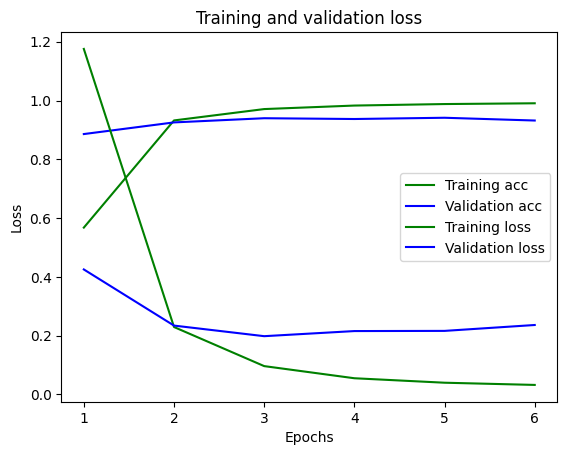

In [121]:
plot_history(history2)

In [122]:
model2.evaluate(x_test2, y_test2)

125/125 [==============================] - 3s 24ms/step - loss: 0.4298 - accuracy: 0.8863


[0.42982882261276245, 0.8862500190734863]

In [123]:
y_test2 = y_test2.argmax(axis=1)

In [124]:
preds2 = model2.predict(x_test2)

125/125 [==============================] - 4s 25ms/step


In [125]:
preds2 = preds2.argmax(axis=1)

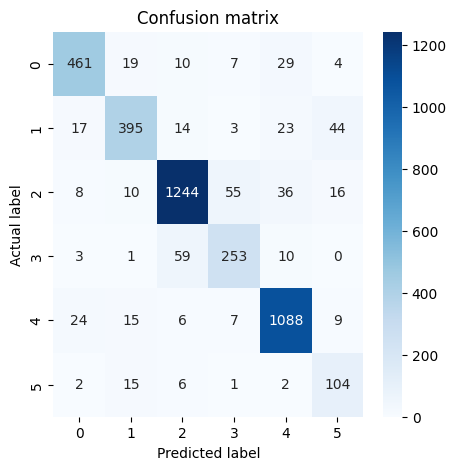

In [126]:
plot_confusion_matrix(y_test2, preds2)

In [127]:
predict_emotion("Wow i was so unaware of the news!", model2)

1/1 [==============================] - 0s 370ms/step


'love'

## Training with entire dataset

In [128]:
dataset = pd.read_csv("../data/emotions.csv")

In [129]:
dataset.head()

,text,label
0,i feel so pissed off over an old friend and so...,anger
1,ive found it has made a huge difference especi...,anger
2,i also feel it is unfortunate that nearly all ...,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was...,sadness


In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


In [131]:
dataset["text"] = dataset["text"].apply(clean_text)

In [132]:
final_count_vectorizer = CountVectorizer()
final_vectorizer = final_count_vectorizer.fit_transform(dataset["text"])
final_vectorizer.shape

(20000, 15079)

In [133]:
final_texts = dataset["text"].tolist()
final_tokenizer = Tokenizer()
final_tokenizer.fit_on_texts(final_texts)

final_word_index = final_tokenizer.word_index
print('Found %s unique tokens.' % len(final_word_index))

Found 15100 unique tokens.


In [134]:
dataset["text"] = dataset["text"].apply(lambda x: final_tokenizer.texts_to_sequences([x])[0])

In [135]:
dataset.head()

,text,label
0,"[1, 401, 167, 43, 43]",anger
1,"[20, 220, 46, 902, 979, 172, 853, 1875, 579, 1...",anger
2,"[40, 1, 653, 1113, 625, 27, 676, 263, 2428, 12...",sadness
3,"[1, 551, 7534]",anger
4,"[222, 194, 2, 3, 479, 502, 3210, 37, 71, 95]",sadness


In [136]:
dataset.head()

,text,label
0,"[1, 401, 167, 43, 43]",anger
1,"[20, 220, 46, 902, 979, 172, 853, 1875, 579, 1...",anger
2,"[40, 1, 653, 1113, 625, 27, 676, 263, 2428, 12...",sadness
3,"[1, 551, 7534]",anger
4,"[222, 194, 2, 3, 479, 502, 3210, 37, 71, 95]",sadness


In [137]:
final_x, final_y = dataset["text"], dataset["label"]

In [138]:
final_x = pad_sequences(final_x, maxlen=120)

In [139]:
final_label_encoder = LabelEncoder()

In [140]:
final_y_encoded = final_label_encoder.fit_transform(final_y)

In [141]:
final_y = to_categorical(final_y_encoded)

In [142]:
final_y[:10]

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [143]:
final_model = build_model(final_word_index)

In [144]:
final_history = final_model.fit(final_x, final_y, epochs=10, batch_size=128,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10


125/125 [==============================] - 813s 7s/step - loss: 1.4101 - accuracy: 0.4570 - val_loss: 0.8108 - val_accuracy: 0.6970
Epoch 2/10
125/125 [==============================] - 726s 6s/step - loss: 0.4268 - accuracy: 0.8646 - val_loss: 0.3420 - val_accuracy: 0.8855
Epoch 3/10
125/125 [==============================] - 254s 2s/step - loss: 0.1296 - accuracy: 0.9590 - val_loss: 0.2818 - val_accuracy: 0.9028
Epoch 4/10
125/125 [==============================] - 1314s 11s/step - loss: 0.0703 - accuracy: 0.9776 - val_loss: 0.3273 - val_accuracy: 0.8938
Epoch 5/10
125/125 [==============================] - 544s 4s/step - loss: 0.0501 - accuracy: 0.9837 - val_loss: 0.3210 - val_accuracy: 0.8988
Epoch 6/10
125/125 [==============================] - 593s 5s/step - loss: 0.0389 - accuracy: 0.9870 - val_loss: 0.3713 - val_accuracy: 0.8950


In [145]:
predict_emotion("I am so ", final_model)

1/1 [==============================] - 1s 1s/step


'anger'

## Answer to questions

- Motivera din modellarkitektur och val av relevanta hyperparametrar.
- Vilka aktiveringsfunktioner har du använt? Varför?
- Vilken loss funktion har du använt? Varför?
- Har du använt någon databehandling? Motivera dina val.
- Har du använt någon regulariseringsteknik? Motivera.
- Hur har modellen utvärderats?
- Är prestandan bra? Varför/ varför inte?
- Vad hade du kunnat göra för att förbättra den ytterligare?
- Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ ai och mer traditionell ai

## Answers

1 - Motivera din modellarkitektur och val av relevanta hyperparametrar.

The model is initialized with a sequetial layer from keras which is used for building a neural network. The Embedding layer is used to convert integer encodings of words (from word_index) into dense vectors of fixed size (here, 128).
The LSTM (Long Short-Term Memory) layer ia a type of recurret neural network (RNN) layer. The LSTM has a layer of 128 neurons, and a dropout of 0.2 as well as a recurrent dropout of 0.2. For the dense layer i used i used 6 neurons which corresponds to the number of classes or sentiments that i am training the model on. The softmax activation is used for multiclass classification. For compiling the model, i used a categorical loss entropy since its suitable for comparing predicted probabilities with the one hot encoded labels. The Adam optimzer is also used and the metric used is accuracy. 
LSTMs are advanced RNNs effective for training data like texts, They are good in remembering long term dependencies, crucial in understanding context in lengthy sequences.
COmplicating the model with many layers didnt improve the result so i kept it very simple

2 - Vilka aktiveringsfunktioner har du använt? Varför?

For Dense layer i used the softmax activation function which is suitable for multi-class tasks like this. The softmax converts the logits or raw output scores from the Dense layer into probabilities that sum up to 1, and each class's probability indicates the network's confidence that the input belongs to that class.

3 - Vilken loss funktion har du använt? Varför?
The loss function used is Categorical_crossentropy. This is typically used in multi class classification where each instance has to be classified into one of many categories.

4 - Har du använt någon databehandling? Motivera dina val.
For each line in the dataset, i created a clean_text function that 
- converts all characters to lower case 
- removes punctuation 
- removes numbers or words containing numbers
- removes new lines
- removes URLs
- removes any https and hrefs that were removed by the point above
- tokenises the texts into individual words 
- removes stop words
- lemmatizes each word

5 - Har du använt någon regulariseringsteknik? Motivera.
None

6 - Hur har modellen utvärderats?

By Doing an evaluation on the test data and plotting a confusion matrix. It lets you visually assess how well the model has performed by comparing the predicted and actual values. Its very useful especially in this task, for understanding the performance on each class in the multi class classification.

7 - Är prestandan bra? Varför/ varför inte?

For this task, i build and train the model on the dataset, then did some data augmentation and finally just trained the model on the entire dataset without any splitting.The model seemed to not significantly make any improvements based the data auugmentation but still ended around an accuracy of 0.89 for regular dataset and the augmented dataset. I have then trained the model on the entire dataset aswell. All in all the models were very good in their predictions.

8 - Vad hade du kunnat göra för att förbättra den ytterligare?

Since i tried a data augmentation without any significant success, I could apply some regularization techniques like L1/L2. I could also try different learning rates or a hyperparameter tuning to get the best parameters for the model

9 - Generativ AI har blivit stort inom text. Beskriv skillnaden mellan generativ ai och mer traditionell ai
Generative AI unlike more traditional AI can create new data points while the latter interpretes and classifies data. While generative AI is often trained on unlabeled data, traditional AI relies alot on labelled data. Furthermore, generative AI can be computationally expensive to train like GPT or AI that deal with images. Lastly some of the best generative AI are linked to art and creative with outputs that are almost impossible to distinguish from human made art. 